In [1]:
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
import matplotlib as mpl
import seaborn as sns
import math

from statistics import median
from scipy.stats import mannwhitneyu
from statsmodels.stats.multitest import fdrcorrection

from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import GridSearchCV
from sklearn import metrics

from sklearn.metrics import roc_curve, roc_auc_score, precision_recall_curve, average_precision_score
from collections import Counter

import shap
from sklearn.metrics import plot_confusion_matrix

In [2]:
import random

random.seed(42)

In [3]:
%config InlineBackend.figure_format = 'png'
plt.rcParams['pdf.fonttype'] = 'truetype'
plt.rcParams['svg.fonttype'] = 'none'
plt.rcParams['figure.dpi'] = 100
plt.rcParams["figure.figsize"] = (10,7)
sns.set_style("whitegrid", {'axes.grid' : False})

#sns.set_style('white')

In [4]:
param_grid = { 
    'n_estimators': [450],
    'max_features': ['auto', 'sqrt', 'log2'],
    'max_depth' : [3,5,7,10,15,20,25,50],
    'criterion' :['gini', 'entropy']
}

In [5]:
metabol = pd.read_csv('Pufa_cascade.tsv', sep='\t')

In [33]:
def select_rank(train, test, genes):
    train_sel = train.copy()
    test_sel = test.copy()
    
    train_sel = train_sel.loc[genes,:]
    test_sel = test_sel.loc[genes,:]
    
    train_sel = train_sel.rank().T
    test_sel = test_sel.rank().T
    
    return train_sel, test_sel

## Tumor VS Adjacent

In [8]:
train_2cls = pd.read_csv('../data_for_python/data/TRAIN_adj_tum_GSE65216_GSE29044_GSE10780.csv' , index_col = 0, sep = '\t')
test_2cls = pd.read_csv('../data_for_python/data/TEST_adj_tum_TCGA_full.csv',index_col = 0, sep = '\t')

In [9]:
y_train = ["Tumor" if x[0:3]=='tum' else "Adjacent" for x in train_2cls.columns]
y_test = ["Tumor" if x[0:3]=='tum' else "Adjacent" for x in test_2cls.columns]

In [10]:
genes_2cls=pd.read_csv('importance_tumadj_33genes.csv')
genes_2cls.columns = ['Genes', 'Adjacent', 'Tumor', 'MeanDecreaseAccuracy','MeanDecreaseGini']

In [11]:
common = set(train_2cls.index).intersection(test_2cls.index)
train_2cls = train_2cls.loc[common,]
test_2cls = test_2cls.loc[common,]

In [34]:
train_x, test_x = select_rank(train_2cls, test_2cls, genes_2cls.Genes)

In [37]:
# clrf = RandomForestClassifier()
# CV_rf = GridSearchCV(estimator=clrf, param_grid=param_grid, cv=7)
# CV_rf.fit(train_x, y_train)
# best = CV_rf.best_params_

In [35]:
best = {'criterion': 'gini',
 'max_depth': 15,
 'max_features': 'sqrt',
 'n_estimators': 450}

## Feature Selection

In [22]:
from mlxtend.feature_selection import SequentialFeatureSelector as SFS

In [23]:
from mlxtend.plotting import plot_sequential_feature_selection as plot_sfs
import matplotlib.pyplot as plt
from sklearn.metrics import balanced_accuracy_score
from sklearn.metrics import make_scorer

In [36]:
clrf = RandomForestClassifier(random_state = 42, 
                              max_features = best['max_features'], 
                              n_estimators = 450,
                              max_depth = best['max_depth'], 
                              criterion = best['criterion'])
#clrf.fit(train_x, y_train)

In [37]:
sffs = SFS(clrf, 
           k_features=len(genes_2cls.Genes), 
           forward=True, 
           floating=True, 
           scoring='roc_auc',
           cv=3,
           n_jobs=-1)

In [38]:
sffs = sffs.fit(train_x, y_train)

In [39]:
print('\nSequential Forward Floating Selection (k=3):')
print(sffs.k_feature_idx_)
print('CV Score:')
print(sffs.k_score_)


Sequential Forward Floating Selection (k=3):
(0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32)
CV Score:
0.9753983897294315


In [40]:
plt.rc('font', size=12)          # controls default text sizes
plt.rc('axes', titlesize=14)     # fontsize of the axes title
plt.rc('axes', labelsize=14)    # fontsize of the x and y labels
plt.rc('xtick', labelsize=12)    # fontsize of the tick labels
plt.rc('ytick', labelsize=12)    # fontsize of the tick labels
plt.rc('legend', fontsize=12)    # legend fontsize
#plt.rc('figure', titlesize=BIGGER_SIZE)

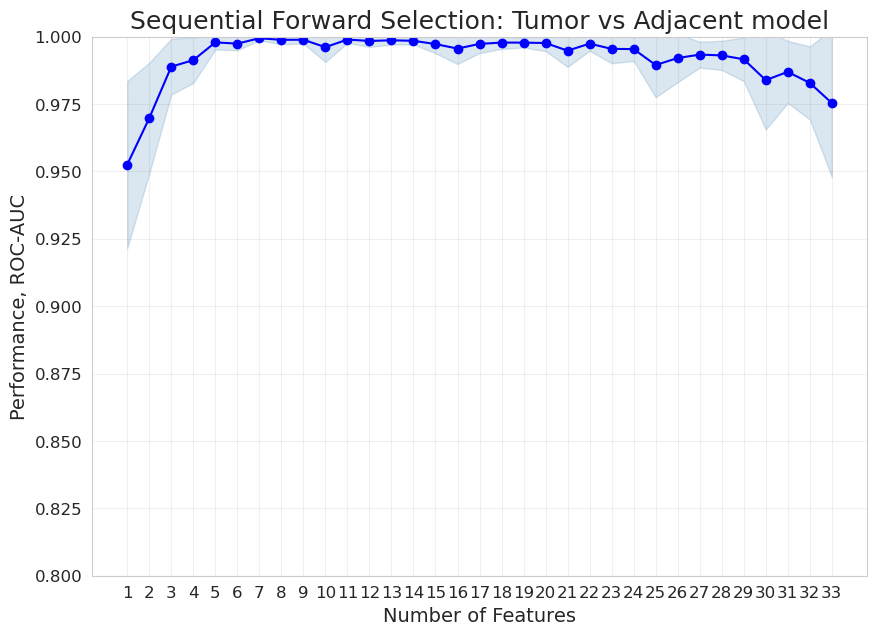

In [41]:
fig1 = plot_sfs(sffs.get_metric_dict(), kind='std_dev')

plt.ylim([0.8, 1])
plt.title('Sequential Forward Selection: Tumor vs Adjacent model', fontdict={'fontsize': 18})
plt.ylabel('Performance, ROC-AUC')
plt.grid(alpha=0.3)
plt.show()

In [42]:
sffs.get_metric_dict()[7]

{'feature_idx': (1, 3, 7, 9, 12, 15, 18),
 'cv_scores': array([0.99832426, 1.        , 1.        ]),
 'avg_score': 0.9994414187962576,
 'feature_names': ('ADIPOR1',
  'HADH',
  'PTGER4',
  'PLA2G15',
  'PLA2G1B',
  'CYP46A1',
  'ACOT7'),
 'ci_bound': 0.0017776546880516357,
 'std_dev': 0.0007899531140193683,
 'std_err': 0.0005585812037425253}